In [1]:
import numpy as np
from numba import njit
from typing import Callable
import os
from utils.methods import rk4, secant
from utils.utilities import y_vacuum, get_ODE_function, get_secant_function

In [2]:
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker
from matplotlib.ticker import FuncFormatter

plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}") 

textwidth_cm = 15.99773
textheight_cm = 22.69678
inch_per_cm = 1 / 2.54
golden_ratio = (np.sqrt(5) - 1) / 2

def formatter(x, pos):
    if np.isclose(x, 0):
        return "0"
    scientific_notation = f"{x:.2e}"
    base, exponent = scientific_notation.split("e")
    return r"${:.2g} \cdot 10^{{{}}}$".format(float(base), int(exponent))

In [3]:
RADIUS = 300

def get_rho(parameter: float) -> Callable[[float], float]:

    amplitude = parameter
    radius = RADIUS

    @njit
    def _rho(x: float) -> float:
            return amplitude if x < radius else 0.0
    return _rho

In [4]:
R_MIN = 1.0 # offset from 0
R_MAX = 1000.0
RK_STEP = -0.05

SECANT_TOLERANCE = 1e-12
SECANT_MAX_ITERS = 50
SECANT_INITIAL_STEP = 1e-6

In [5]:
def f(alpha) -> float:
    return alpha**5 / (1 + alpha**2)**3

def condition(alpha, amplitude, radius) -> float:
    return amplitude * radius**2 - 3 * f(alpha)**2 / (2 * np.pi)

In [6]:
def u(r, alpha) -> float:
    return np.sqrt(RADIUS * alpha / (r**2 + (RADIUS * alpha)**2))

def C(amplitude) -> float:
    return (2 * np.pi * amplitude / 3)**(-1/4)

def psi(r, alpha, amplitude, radius):
    if r < radius:
        return C(amplitude) * u(r, alpha)
    else:
        beta = radius * (C(amplitude) * u(radius, alpha) - 1)
        return 1 + beta / r

In [7]:

exact_critical_amplitude = 3 / (2 *np.pi * RADIUS**2) * 5**5 / 6**6
exact_critical_ADM_mass = 2 / 5 * RADIUS
exact_critical_alpha = np.sqrt(5)
exact_critical_rest_mass = 18/125 * (9 * np.sqrt(5) * np.arctan(1/np.sqrt(5))-5) * RADIUS

In [8]:
print(f"Exact critical amplitude: {exact_critical_amplitude}")
print(f"Exact critical ADM mass: {exact_critical_ADM_mass}")
print(f"Exact critical alpha: {exact_critical_alpha}")
print(f"Exact critical rest mass: {exact_critical_rest_mass}")

Exact critical amplitude: 3.553377894677161e-07
Exact critical ADM mass: 120.0
Exact critical alpha: 2.23606797749979
Exact critical rest mass: 149.60549858869624


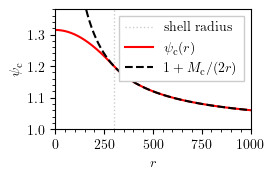

In [ ]:
psi_c = lambda r: psi(r, exact_critical_alpha, exact_critical_amplitude, RADIUS)
r_vals = np.linspace(0.0000001, R_MAX, 1000)
psi_c_vals = np.array([psi_c(r) for r in r_vals])
outer_sol_vals = [1 + RADIUS/(5*r) for r in r_vals]


scale = 0.4
fig_width_inches = textwidth_cm * inch_per_cm * scale
fig_height_inches = fig_width_inches * golden_ratio

fig, ax = plt.subplots(figsize=(fig_width_inches, fig_height_inches))




ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\psi_{\text{c}}$")
ax.set_xlim(0, R_MAX)
ax.set_ylim(1, np.max(psi_c_vals) * 1.05)

ax.axvline(x=RADIUS, color='black', linestyle="dotted", linewidth=1, alpha=0.2, label=f"shell radius")



ax.plot(r_vals, psi_c_vals, color="red", linewidth=1.5, label=r"$\psi_{\text{c}}(r)$")
ax.plot(r_vals, outer_sol_vals, color="black", linewidth=1.5, linestyle="dashed", label=r"$1 + M_{\text{c}} / (2r)$")

ax.legend(loc='upper right', frameon=True, framealpha=1, fancybox=False)

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
 

plt.savefig("img/psi_c.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [10]:
selected_amplitude = 1e-8
rho = get_rho(selected_amplitude)
ode = get_ODE_function(rho, exponent=5)
sec = get_secant_function(rho, R_MAX, R_MIN, RK_STEP, exponent=5)

In [11]:
N = 500
tol = 1e-12
max_iters = 20
alphas = np.linspace(0, 1000, N)
sec_vals = [sec(alpha) for alpha in alphas]

In [12]:
# test the secant method
alpha_guesses = np.linspace(0, 2000, 200)
secant_results = []

secant_failed_guesses = []
negative_root_guesses = []
decreasing_psi_guesses = []
working_guesses = []

negative_root_ADM_mass = []
decreasing_psi_ADM_mass = []
working_ADM_mass_vals = []

negative_root_dpsi_at_zero_vals = []
decreasing_psi_dpsi_at_zero_vals = []
working_dpsi_at_zero_vals = []


for i, alpha in enumerate(alpha_guesses):
    iters, _, success = secant(sec, SECANT_TOLERANCE, SECANT_MAX_ITERS, alpha, SECANT_INITIAL_STEP)
    if success:
        if iters is None:
            print(f"[{i}/✗] secant method failed for initial guess {2*alpha:.4g}")
            secant_failed_guesses.append(2 * alpha)
            continue
        root = iters[-1]
        x, y = rk4(ode, R_MAX, y_vacuum(root, R_MAX), R_MIN, RK_STEP)
        if root > 0 and np.all(y[:,0] > 0): # M_ADM > 0 and Ψ > 0
            print(f"[{i}/✓] ADM mass ≈ {2*root:.4g}, Ψ'(0) ≈ {y[:,1][-1]:.4g} for initial guess {2*alpha:.4g} after {len(iters)} iterations")
            working_ADM_mass_vals.append(2 * root)
            working_dpsi_at_zero_vals.append(y[-1][1])
            working_guesses.append(2 * alpha)
        elif root < 0:
            print(f"[{i}/✗] converged to negative root for initial guess {2*alpha:.4g} after {len(iters)} iterations")
            negative_root_ADM_mass.append(2 * root)
            negative_root_dpsi_at_zero_vals.append(y[-1][1])
            negative_root_guesses.append(2 * alpha)
        elif np.any(y[:,0] < 0):
            print(f"[{i}/✗] Ψ < 0 somewhere, for root for initial guess {2*alpha:.4g} after {len(iters)} iterations")
            decreasing_psi_ADM_mass.append(2 * root)
            decreasing_psi_dpsi_at_zero_vals.append(y[-1][1])
            decreasing_psi_guesses.append(2 * alpha)

    else:
        print(f"[{i}/✗] secant method failed for initial guess {2*alpha:.4g} after {len(iters)} iterations")
        secant_failed_guesses.append(2 * alpha)

[0/✓] ADM mass ≈ 1.144, Ψ'(0) ≈ -2.969e-14 for initial guess 0 after 1 iterations
[1/✓] ADM mass ≈ 1.144, Ψ'(0) ≈ 5.097e-15 for initial guess 20.1 after 1 iterations
[2/✓] ADM mass ≈ 1.144, Ψ'(0) ≈ 9.784e-13 for initial guess 40.2 after 1 iterations
[3/✓] ADM mass ≈ 1.144, Ψ'(0) ≈ -2.8e-15 for initial guess 60.3 after 1 iterations
[4/✓] ADM mass ≈ 1.144, Ψ'(0) ≈ -3.157e-14 for initial guess 80.4 after 1 iterations
[5/✗] converged to negative root for initial guess 100.5 after 1 iterations
[6/✗] converged to negative root for initial guess 120.6 after 1 iterations
[7/✗] secant method failed for initial guess 140.7 after 1 iterations
[8/✗] converged to negative root for initial guess 160.8 after 1 iterations
[9/✗] converged to negative root for initial guess 180.9 after 1 iterations
[10/✗] converged to negative root for initial guess 201 after 1 iterations
[11/✗] secant method failed for initial guess 221.1 after 1 iterations
[12/✗] converged to negative root for initial guess 241.2 afte

In [14]:
# save the results

np.savez("data/secant_results.npz",
    secant_failed_guesses=secant_failed_guesses,
    negative_root_guesses=negative_root_guesses,
    decreasing_psi_guesses=decreasing_psi_guesses,
    working_guesses=working_guesses,
    negative_root_ADM_mass=negative_root_ADM_mass,
    decreasing_psi_ADM_mass=decreasing_psi_ADM_mass,
    working_ADM_mass_vals=working_ADM_mass_vals,
    negative_root_dpsi_at_zero_vals=negative_root_dpsi_at_zero_vals,
    decreasing_psi_dpsi_at_zero_vals=decreasing_psi_dpsi_at_zero_vals,
    working_dpsi_at_zero_vals=working_dpsi_at_zero_vals
)

if os.path.exists("data/secant_results.npz"):
    print("Loading existing secant results...")

    secant_results = np.load("data/secant_results.npz", allow_pickle=True)
    secant_failed_guesses = secant_results["secant_failed_guesses"]
    negative_root_guesses = secant_results["negative_root_guesses"]
    decreasing_psi_guesses = secant_results["decreasing_psi_guesses"]
    working_guesses = secant_results["working_guesses"]
    negative_root_ADM_mass = secant_results["negative_root_ADM_mass"]
    decreasing_psi_ADM_mass = secant_results["decreasing_psi_ADM_mass"]
    working_ADM_mass_vals = secant_results["working_ADM_mass_vals"]
    negative_root_dpsi_at_zero_vals = secant_results["negative_root_dpsi_at_zero_vals"]
    decreasing_psi_dpsi_at_zero_vals = secant_results["decreasing_psi_dpsi_at_zero_vals"]
    working_dpsi_at_zero_vals = secant_results["working_dpsi_at_zero_vals"]
    # Plot the results

Loading existing secant results...


In [15]:
decimals = 3  # number of decimal places to round to

unique_working_ADM_mass_vals = np.unique(np.round(working_ADM_mass_vals, decimals=decimals))
unique_negative_root_ADM_mass = np.unique(np.round(negative_root_ADM_mass, decimals=decimals))
unique_decreasing_psi_ADM_mass = np.unique(np.round(decreasing_psi_ADM_mass, decimals=decimals))

print(f"unique working ADM mass values: {unique_working_ADM_mass_vals}")
print(f"unique negative root ADM mass values: {unique_negative_root_ADM_mass}")
print(f"unique decreasing psi ADM mass values: {unique_decreasing_psi_ADM_mass}")

unique working ADM mass values: [1.144000e+00 1.355508e+03]
unique negative root ADM mass values: [-2098.105  -298.253]
unique decreasing psi ADM mass values: [1657.247 2219.421 2744.706 3216.03  4033.187]


In [16]:
sec_vals_ADM = [sec(_a) for _a in alpha_guesses]

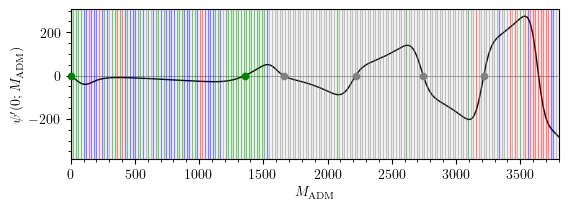

In [ ]:
scale = 1
fig_width_inches = textwidth_cm * inch_per_cm * scale
fig_height_inches = fig_width_inches * golden_ratio * 0.5

plt.figure(figsize=(fig_width_inches, fig_height_inches))
plt.xlabel(r"$M_{\text{ADM}}$")
plt.ylabel(r"$\psi'(0; M_{\text{ADM}})$")
plt.axhline(y=0, color='black', linestyle="solid", linewidth=0.5, alpha=0.5)

plt.plot([2*_a for _a in alpha_guesses], sec_vals_ADM, linewidth=1, color="black")

for guess in working_guesses:
    plt.axvline(x=guess, color='green', linestyle="solid", linewidth=1, alpha=0.5)

for guess in negative_root_guesses:
    plt.axvline(x=guess, color='blue', linestyle="solid", linewidth=1, alpha=0.5)

for guess in decreasing_psi_guesses:
    plt.axvline(x=guess, color='gray', linestyle="solid", linewidth=1, alpha=0.5)

for guess in secant_failed_guesses:
    plt.axvline(x=guess, color='red', linestyle="solid", linewidth=1, alpha=0.5)



for unique_adm_mass in unique_working_ADM_mass_vals:
    plt.scatter(unique_adm_mass, 0, color="green", marker=".", s=80, alpha=1, clip_on=False, zorder=100)

for unique_adm_mass in unique_decreasing_psi_ADM_mass:
    plt.scatter(unique_adm_mass, 0, color="gray", marker=".", s=80, alpha=1, clip_on=False, zorder=100)

# add minor ticks

plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.xlim(2*alpha_guesses[0], 2*alpha_guesses[-1] * 0.95)
plt.savefig("img/secant_results.pdf", bbox_inches='tight', dpi=300)

In [18]:
# discrete Linf norm (maximum norm)
def linf_norm(u):
    return np.max(np.abs(u))

# discrete L2 norm
def l2_norm(u, h):
    return np.sqrt(np.sum(h * u**2))

In [19]:
# steps = np.linspace(0.001, 0.1, 100)
steps = np.logspace(-3, -1, 100)
rho = get_rho(exact_critical_amplitude)
ode = get_ODE_function(rho, exponent=5)

L2_vals = []
Linf_vals = []

for step in steps:
    _x, y = rk4(ode, R_MAX, y_vacuum(RADIUS / 5, R_MAX), R_MIN, -step)
    psi_vals = y[:, 0]
    r_vals = _x
    psi_c_vals = np.array([psi_c(r) for r in r_vals])

    err = psi_vals - psi_c_vals
    
    L2, Linf = l2_norm(err, step), linf_norm(err)
    L2_vals.append(L2)
    Linf_vals.append(Linf)

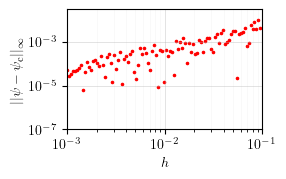

In [ ]:
scale = 0.4
fig_width_inches = textwidth_cm * inch_per_cm * scale
fig_height_inches = fig_width_inches * golden_ratio

fig, ax = plt.subplots(figsize=(fig_width_inches, fig_height_inches))

ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.5, which='major')
ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
ax.minorticks_on()


ax.scatter(steps, Linf_vals, marker='.', color="red", s=10)


ax.xaxis.get_offset_text().set_visible(False)
ax.yaxis.get_offset_text().set_visible(False)


ax.set_ylabel(r"$|| \psi - \psi_{\text{c}} ||_{\infty}$")
ax.set_xlabel(r"$h$")
plt.yscale('log')
plt.xscale('log')
ax.set_xlim(steps[0], steps[-1])
ax.set_ylim(bottom=1e-7)

plt.savefig("img/psi_error.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [21]:
steps = np.logspace(-3, -1, 100)
rho = get_rho(exact_critical_amplitude)
ode = get_ODE_function(rho, exponent=5)
differences = []
for step in steps:
    x, y = rk4(ode, R_MAX, y_vacuum(exact_critical_ADM_mass/2, R_MAX), R_MIN, -step)
    r = np.flip(x)
    psi_r = np.flip(y[:, 0])
    rho_r = [rho(_r) for _r in r]
    rest_mass = [0] # rest mass at r = 0 is
    integral = 0.0

    for k in range(1, len(r)):
        delta_r_k = r[k] - r[k - 1]
        integral += 0.5 * (psi_r[k]**6 * rho_r[k] * r[k]**2 + psi_r[k - 1]**6 * rho_r[k - 1] * r[k - 1]**2) * delta_r_k
    numerical_rest_mass = 4 * np.pi * integral
    difference = exact_critical_rest_mass - numerical_rest_mass
    differences.append(difference)

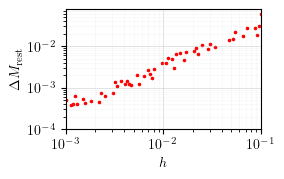

In [ ]:
scale = 0.4
fig_width_inches = textwidth_cm * inch_per_cm * scale
fig_height_inches = fig_width_inches * golden_ratio

fig, ax = plt.subplots(figsize=(fig_width_inches, fig_height_inches))

ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.5, which='major')
ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
ax.minorticks_on()

ax.scatter(steps, differences, marker='.', color="red", s=10)


ax.yaxis.set_major_formatter(FuncFormatter(formatter))

ax.xaxis.get_offset_text().set_visible(False)
ax.yaxis.get_offset_text().set_visible(False)


ax.set_ylabel(r"$\Delta M_{\text{rest}}$")
ax.set_xlabel(r"$h$")
plt.yscale('log')
plt.xscale('log')
ax.set_xlim(steps[0], steps[-1])
ax.set_ylim(bottom=1e-4)

plt.savefig("img/rest_mass_error.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [23]:
steps = np.logspace(-3, -1, 100)
rho = get_rho(exact_critical_amplitude)
ode = get_ODE_function(rho, exponent=5)
differences = []
for step in steps:
    x, y = rk4(ode, R_MAX, y_vacuum(exact_critical_ADM_mass/2, R_MAX), R_MIN, -step)
    r = np.flip(x)
    psi_r = np.flip(y[:, 0])
    rho_r = [rho(_r) for _r in r]
    adm_mass = [0] # rest mass at r = 0 is
    integral = 0.0

    for k in range(1, len(r)):
        delta_r_k = r[k] - r[k - 1]
        integral += 0.5 * (psi_r[k]**5 * rho_r[k] * r[k]**2 + psi_r[k - 1]**5 * rho_r[k - 1] * r[k - 1]**2) * delta_r_k
    numerical_adm_mass = 4 * np.pi * integral
    difference = exact_critical_ADM_mass - numerical_adm_mass
    differences.append(difference)

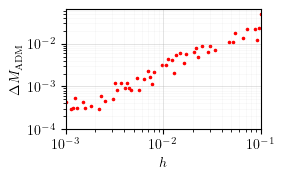

In [ ]:
scale = 0.4
fig_width_inches = textwidth_cm * inch_per_cm * scale
fig_height_inches = fig_width_inches * golden_ratio

fig, ax = plt.subplots(figsize=(fig_width_inches, fig_height_inches))

ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.5, which='major')
ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
ax.minorticks_on()

ax.scatter(steps, differences, marker='.', color="red", s=10)


ax.yaxis.set_major_formatter(FuncFormatter(formatter))

ax.xaxis.get_offset_text().set_visible(False)
ax.yaxis.get_offset_text().set_visible(False)


ax.set_ylabel(r"$\Delta M_{\text{ADM}}$")
ax.set_xlabel(r"$h$")
plt.yscale('log')
plt.xscale('log')
ax.set_xlim(steps[0], steps[-1])
ax.set_ylim(bottom=1e-4)

plt.savefig("img/adm_mass_error.pdf", bbox_inches='tight', dpi=300)
plt.show()